<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/SVM_BC_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)

# Load data and convert to DataFrame
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

In [150]:
# df.describe().T

In [151]:
df.size

17639

In [152]:
# --------------------------
# 2. Prepare Data
# --------------------------
X = df.drop(columns='target')
y = df['target']

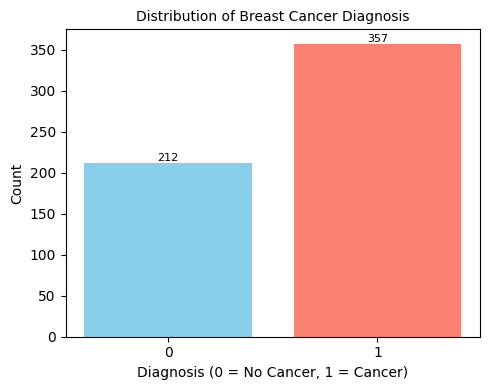

In [153]:
# Replotting with reduced figure size
fig, ax = plt.subplots(figsize=(5, 4))  # Smaller size (width=5, height=3)
bars = ax.bar(target_counts.index.astype(str), target_counts.values, color=['skyblue', 'salmon'])
ax.set_xlabel('Diagnosis (0 = No Cancer, 1 = Cancer)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Breast Cancer Diagnosis', fontsize=10)
ax.bar_label(bars, fontsize=8)

plt.tight_layout()
save_path = "diagnosis_distribution.png"
plt.savefig(save_path, dpi=300)
plt.show()

Workflow Summary:

1. Split your dataset into training and testing sets.

2. Apply oversampling (e.g., SMOTE) only to the training data.

3. Perform feature selection on the oversampled training data.

4. Train your model on the selected features.

5. Evaluate on the original (untouched) test set.

In [154]:
!pip install imbalanced-learn

In [155]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Split the data before oversampling to avoid data leakage
X_train_o, X_test, y_train_o, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_o, y_train_o)

# Step 3: Display new class distribution
print("Original training set class distribution:\n", y_train_o.value_counts())
print("\nResampled training set class distribution:\n", pd.Series(y_train).value_counts())

Original training set class distribution:
 target
1    285
0    170
Name: count, dtype: int64

Resampled training set class distribution:
 target
1    285
0    285
Name: count, dtype: int64


In [156]:
X_train.shape

(570, 30)

In [157]:
X_test.shape

(114, 30)

In [158]:
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns

# Step 1: Feature selection using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X_train, y_train)

# Get selected feature names
selected_mask = selector.get_support()
selected_features = X_train.columns[selected_mask]
X_train_selected = X_train[selected_features]

# 4. Apply same selection to test set (transform only)
X_test_selected = selector.transform(X_test)

In [159]:
X_train_selected.shape

(570, 5)

In [160]:
X_test_selected.shape

(114, 5)

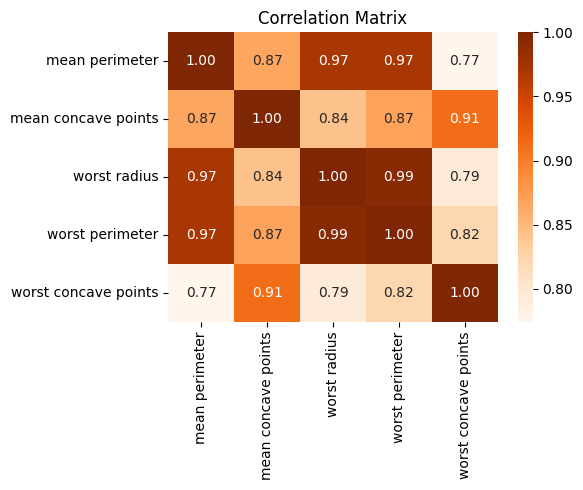

In [173]:
plt.figure(figsize=(6, 5))
corr_matrix = X_train_selected.corr()
sns.heatmap(corr_matrix, annot=True, cmap='Oranges', fmt=".2f")

plt.title("Correlation Matrix")
plt.tight_layout()
plt.savefig("correlation_matrix_selected_features_rotated.png", dpi=300)
plt.show()


In [ ]:
# Kernels to evaluate
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Store metrics and models
results = []
trained_models = {}

# --------------------------
# 3. Train & Evaluate Models
# --------------------------
for kernel in kernels:
    model = SVC(kernel=kernel, C=1.0, gamma='scale')
    model.fit(X_train_selected, y_train)
    trained_models[kernel] = model  # store for later use

    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)

    train_metrics = [
        accuracy_score(y_train, y_train_pred),
        precision_score(y_train, y_train_pred),
        recall_score(y_train, y_train_pred),
        f1_score(y_train, y_train_pred)
    ]
    test_metrics = [
        accuracy_score(y_test, y_test_pred),
        precision_score(y_test, y_test_pred),
        recall_score(y_test, y_test_pred),
        f1_score(y_test, y_test_pred)
    ]

    results.append({
        'Kernel': kernel,
        'Train Accuracy': train_metrics[0],
        'Train Precision': train_metrics[1],
        'Train Recall': train_metrics[2],
        'Train F1': train_metrics[3],
        'Test Accuracy': test_metrics[0],
        'Test Precision': test_metrics[1],
        'Test Recall': test_metrics[2],
        'Test F1': test_metrics[3]
    })

results_df = pd.DataFrame(results)
print("\n SVM Performance on Breast Cancer Dataset:")
print(results_df)

# --------------------------
# 4. Select Best Model
# --------------------------
best_kernel = results_df.sort_values(by='Test Accuracy', ascending=False).iloc[0]['Kernel']
print(f"\nBest kernel based on test accuracy: {best_kernel}")

# Get the best model
best_model = trained_models[best_kernel]

# Predict with best model
y_train_best = best_model.predict(X_train_selected)
y_test_best = best_model.predict(X_test_selected)

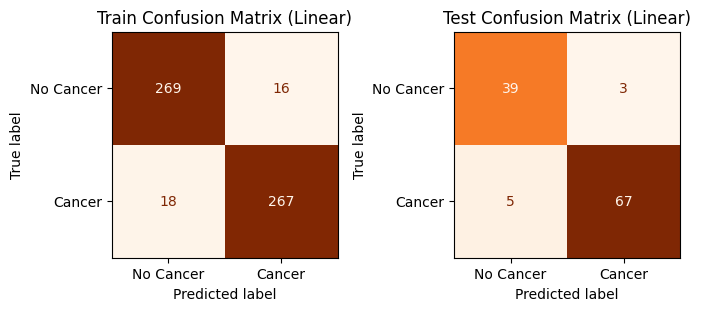

In [169]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

class_names = ['No Cancer', 'Cancer']
best_kernel = "Linear"

# Plotting with a new colormap (e.g., 'Oranges')
fig, axs = plt.subplots(1, 2, figsize=(7, 5))

cm_train = confusion_matrix(y_train, y_train_best)
cm_test = confusion_matrix(y_test, y_test_best)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)

disp_train.plot(ax=axs[0], cmap='Oranges', colorbar=False, values_format='d')
axs[0].set_title(f"Train Confusion Matrix ({best_kernel})", fontsize=12)
axs[0].tick_params(labelsize=10)

disp_test.plot(ax=axs[1], cmap='Oranges', colorbar=False, values_format='d')
axs[1].set_title(f"Test Confusion Matrix ({best_kernel})", fontsize=12)
axs[1].tick_params(labelsize=10)

plt.tight_layout()
save_path = "confusion_matrix_best_model.png"
plt.savefig(save_path, dpi=300)
plt.show()


In [164]:
# df.describe().T

In [165]:
# Create a DataFrame of results
results_df = pd.DataFrame(results)
print("\nSVM Performance on Breast Cancer Dataset:")
results_df


SVM Performance on Breast Cancer Dataset:


,Kernel,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,linear,0.940351,0.943463,0.936842,0.940141,0.929825,0.957143,0.930556,0.943662
1,rbf,0.910526,0.892617,0.933333,0.912521,0.921053,0.956522,0.916667,0.936170
2,poly,0.915789,0.896321,0.940351,0.917808,0.921053,0.956522,0.916667,0.936170
3,sigmoid,0.103509,0.099291,0.098246,0.098765,0.105263,0.187500,0.125000,0.150000


In [166]:
model

SVC(kernel='sigmoid')

**SHAP**

It stands for SHapley Additive exPlanations. This method aims to explain the prediction of an instance/observation by computing the contribution of each feature to the prediction, and it can be installed using the following pip command.

In [ ]:
!pip install shap

**Dependence Plot**

Unlike summary plots, dependence plots show the relationship between a specific feature and the predicted outcome for each instance within the data. This analysis is performed for multiple reasons and is not limited to gaining more granular information and validating the importance of the feature being analyzed by confirming or challenging the findings from the summary plots or other global feature importance measures.

  0%|          | 0/114 [00:00<?, ?it/s]

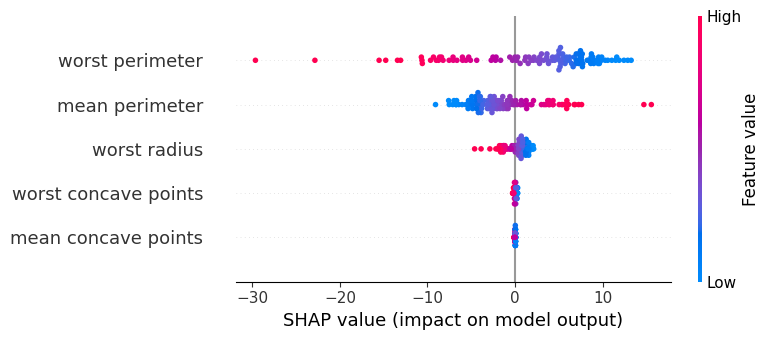

<Figure size 640x480 with 0 Axes>

Top SHAP features based on importance:
- worst perimeter
- mean perimeter
- worst radius
- worst concave points
- mean concave points


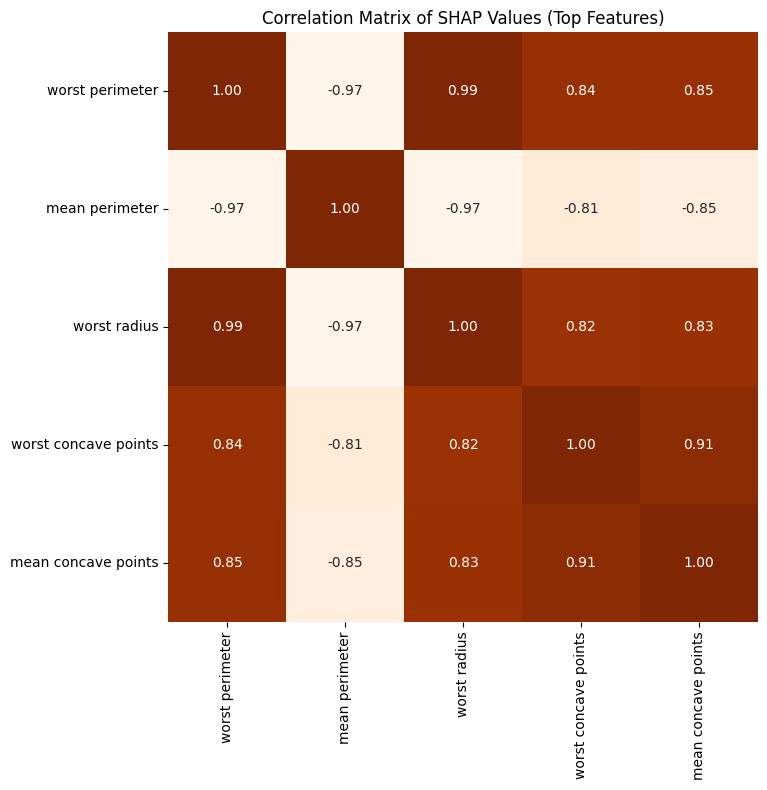

Features used in correlation matrix (auto_feature_names): ['worst perimeter', 'mean perimeter', 'worst radius', 'worst concave points', 'mean concave points']


In [168]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use model's probability or decision function for SHAP
if hasattr(best_model, "predict_proba"):
    model_predict_function = best_model.predict_proba
else:
    model_predict_function = best_model.decision_function

# Sample background dataset from training data
X_background = shap.sample(X_train_selected, 100, random_state=0)

# Create SHAP explainer
explainer = shap.KernelExplainer(model_predict_function, X_background)

# Compute SHAP values on test set
shap_values = explainer.shap_values(X_test_selected, nsamples=100)

# If binary classification, use SHAP values for positive class (index 1)
if isinstance(shap_values, list):
    shap_values_for_df = shap_values[1]
else:
    shap_values_for_df = shap_values

# Get selected feature names from the selector
selected_feature_names = X.columns[selector.get_support()]

# Create DataFrame of SHAP values with column names
shap_df = pd.DataFrame(shap_values_for_df, columns=selected_feature_names)

# Plot SHAP summary plot (with feature names shown)
shap.summary_plot(shap_values_for_df, X_test_selected, feature_names=selected_feature_names)
plt.savefig("SHAP_values_summary.png", dpi=300)
plt.show()

# Calculate mean absolute SHAP values to find top features
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)
top_n = 5
top_features = mean_abs_shap.head(top_n).index.tolist()

print("Top SHAP features based on importance:")
for feature in top_features:
    print(f"- {feature}")

# Correlation analysis of top SHAP features
top_shap_df = shap_df[top_features]
correlation_matrix = top_shap_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Oranges", square=True, cbar=False)
plt.title("Correlation Matrix of SHAP Values (Top Features)")
plt.tight_layout()
plt.savefig("SHAP_correlation_matrix_top_features.png", dpi=300)
plt.show()

# Get top feature names from the correlation matrix
auto_feature_names = correlation_matrix.columns.tolist()
print("Features used in correlation matrix (auto_feature_names):", auto_feature_names)

# # Plot SHAP dependence plots for each top feature
# for feature_name in auto_feature_names:
#     print(f"\nGenerating SHAP dependence plot for: {feature_name}")
#     shap.dependence_plot(
#         feature_name,
#         shap_values_for_df,
#         X_test_selected,
#         feature_names=selected_feature_names,
#         show=True
#     )
#     # Save each plot with feature name in filename
#     plot_filename = f"shap_dependence_{feature_name.replace(' ', '_')}.png"
#     plt.savefig(plot_filename, dpi=300)
#     plt.clf()  # Clear the plot before the next one
